# 01. PSPNet Pascal VOC

In [548]:
import os
import random
import torch
import cv2
import torchvision
import matplotlib.pyplot as plt

## 1. Loading the Pascal VOC dataset

### 1.1 Setup transforms

In [549]:
import torchvision.transforms as transforms

data_transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])

### 1.2 Loading datasets

In [560]:
from torchvision import datasets

train_data = datasets.VOCSegmentation(root="./data",
                            year="2012",
                            image_set="train",
                            download="true",
                            transform=data_transform,
                            target_transform=data_transform)

test_data = datasets.VOCSegmentation(root="./data",
                                year="2012",
                                image_set="val",
                                download="true",
                                transform=data_transform,
                                target_transform=data_transform)

viz_data = datasets.VOCSegmentation(root="./data", year="2012", image_set="train")

Using downloaded and verified file: ./data\VOCtrainval_11-May-2012.tar
Extracting ./data\VOCtrainval_11-May-2012.tar to ./data
Using downloaded and verified file: ./data\VOCtrainval_11-May-2012.tar
Extracting ./data\VOCtrainval_11-May-2012.tar to ./data


### 1.3 Visualizing the data

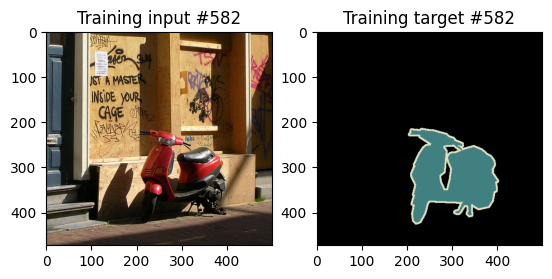

In [561]:
random_index = random.randint(0, len(viz_data))
(image, target) = viz_data[random_index]
plt.subplot(1, 2, 1)
plt.title("Training input #{id}".format(id = random_index))
plt.imshow(image)
plt.subplot(1, 2, 2)
plt.title("Training target #{id}".format(id = random_index))
plt.imshow(target)

### 1.4 Prepare DataLoader

In [552]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataloader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=False)

print(f"train_dataloader: {len(train_dataloader)} * {BATCH_SIZE} images")
print(f"test_dataloader: {len(test_dataloader)} * {BATCH_SIZE} images")

train_dataloader: 46 * 32 images
test_dataloader: 46 * 32 images


## 2. Setup model

In [589]:
train_features_batch = next(iter(train_dataloader))[0]
train_features_batch.shape

torch.Size([32, 3, 224, 224])

In [609]:
from torch import nn
import torch.nn.functional as F

class PyramidPoolingModule(nn.Module):
    
    def __init__(self, pools, in_channels, input_shape):
        super().__init__()
        self.input_shape = input_shape
        self.pooling_layers = [
            nn.Sequential(
                nn.AdaptiveAvgPool2d(output_size=p), # Pool
                nn.Conv2d(in_channels=in_channels, out_channels=int(in_channels/len(pools)), kernel_size=1) # Conv
            ) 
            for p in pools
        ]
        
    def forward(self, x):
        outputs = [x]
        for pooling_layer in self.pooling_layers:
            x = pooling_layer(x)
            outputs.append(F.interpolate(x, size=(224, 224), mode="bilinear", align_corners=True))

        return torch.cat(outputs, dim=1)
            

In [569]:
from torch import nn
from torchvision import models

class PSPNetModel(nn.Module):
    def __init__(self, 
                 input_shape, 
                 pools = (6, 3, 2, 1)):
        
        self.feature_extractor = models.resnet50(weights=torchvision.models.ResNet50_Weights.DEFAULT)
        self.pyramid_pooling_module = PyramidPoolingModule(pools, 128, (224, 224))

In [642]:
class FeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet = models.resnet50(weights=torchvision.models.ResNet50_Weights.DEFAULT)
        # Change first conv layer to accept single-channel (grayscale) input
        # self.resnet.conv1.weight = torch.nn.Parameter(self.resnet.conv1.weight.sum(dim=1).unsqueeze(1))

    def forward(self, x):
        return x

In [644]:
from torch import nn
import torch.nn.functional as F

class PyramidPoolingModule(nn.Module):

    def __init__(self, pools, in_channels, input_shape):
        super().__init__()
        self.input_shape = input_shape
        self.pooling_layers = [
            nn.Sequential(
                nn.AdaptiveAvgPool2d(output_size=p), # Pool
                nn.Conv2d(in_channels=in_channels, out_channels=int(in_channels/len(pools)), kernel_size=1) # Conv
            )
            for p in pools
        ]

    def forward(self, x):
        outputs = [x]
        for pooling_layer in self.pooling_layers:
            x = pooling_layer(x)
            outputs.append(F.interpolate(x, size=self.input_shape, mode="bilinear", align_corners=True))

        return torch.cat(outputs, dim=1)


class PSPNetModel(nn.Module):
    def __init__(self,
                 pools = (1, 2, 3, 6)):
        super().__init__()
        self.feature_extractor = FeatureExtractor()
        self.pyramid_pooling_module = PyramidPoolingModule(pools, 3, (224, 224))
        
    def forward(self, x):
        extracted_features = self.feature_extractor(x)
        #print(extracted_features.shape)
        #pyramid_pooling_output = self.pyramid_pooling_module(extracted_features)
        return extracted_features

#test = PyramidPoolingModule((6, 3, 2, 1), 3, (224, 224))
#sample_1 = next(iter(train_dataloader))[0]
#yep = test(sample_1)
#sample_1.shape, yep.shape

testmodel = models.resnet50(weights=torchvision.models.ResNet50_Weights.DEFAULT)
sample_1 = next(iter(train_dataloader))[0]
yep = testmodel(sample_1)
sample_1.shape, yep.shape


(torch.Size([32, 3, 224, 224]), torch.Size([32, 1000]))

In [641]:
model = PSPNetModel()
with torch.no_grad():
    for batch in train_dataloader:
        x = batch[0].to("cpu")
        test_pred = model(x)
        break

RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [1, 1]

In [639]:
from torchinfo import summary

model = models.resnet50(weights=torchvision.models.ResNet50_Weights.DEFAULT)

summary(
    model,
    input_size=(32, 3, 256, 256),
    col_names=["output_size", "num_params"],
)

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [32, 1000]                --
├─Conv2d: 1-1                            [32, 64, 128, 128]        9,408
├─BatchNorm2d: 1-2                       [32, 64, 128, 128]        128
├─ReLU: 1-3                              [32, 64, 128, 128]        --
├─MaxPool2d: 1-4                         [32, 64, 64, 64]          --
├─Sequential: 1-5                        [32, 256, 64, 64]         --
│    └─Bottleneck: 2-1                   [32, 256, 64, 64]         --
│    │    └─Conv2d: 3-1                  [32, 64, 64, 64]          4,096
│    │    └─BatchNorm2d: 3-2             [32, 64, 64, 64]          128
│    │    └─ReLU: 3-3                    [32, 64, 64, 64]          --
│    │    └─Conv2d: 3-4                  [32, 64, 64, 64]          36,864
│    │    └─BatchNorm2d: 3-5             [32, 64, 64, 64]          128
│    │    └─ReLU: 3-6                    [32, 64, 64, 64]          --
│ 

In [645]:
model = PSPNetModel()

summary(
    model,
    input_size=(32, 3, 256, 256),
    col_names=["output_size", "num_params"],
)

Layer (type:depth-idx)                   Output Shape              Param #
PSPNetModel                              [32, 3, 256, 256]         --
├─FeatureExtractor: 1-1                  [32, 3, 256, 256]         25,557,032
Total params: 25,557,032
Trainable params: 25,557,032
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0
Input size (MB): 25.17
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 25.17